# 0. Import Modules and Setup Global Variables

In [2]:
import cv2, os
import numpy as np
import math as m
from matplotlib import pyplot as plt
%matplotlib inline
print(os.getcwd())

c:\Users\Hai\Documents\UQ\UQ 2022 - Sixth Year\METR4911_ML_Python\MaskRCNN-Notebook


In [3]:
############################ Global variables used in object_detection_mask() function ############################
# Fruit/Vegetable/Object Parameters
# coco_labels.txt, Labels for fruit/vegetable (6 labels)
LABELS = {0: "Person", 51: "Banana", 52: "Apple", 54: "Orange", 55: "Broccoli", 56: "Carrot"}

# Color in BGR in CV2 not RGB, match color with object's color in object_detection_mask() function
COLORS = {"Person": (179,179,255), "Banana": (72,216,255), "Apple": (0,8,255), 
         "Carrot": (33,145,237), "Orange": (0,126,255), "Broccoli": (0,255,74)}

# Object Detect Mask and Score Threshold in object_detection_mask() function
MASK_THRESHOLD = 0.65
SCORE_THRESHOLD = 0.75

############################ Global variables used in Item() and Finger(Item) class ############################
# TODO: Adjust the volume cm3 based on shape of item (need to update from testing the mass obtained vs real life mass)
ITEM_VOLUME_ADJUSTMENT = {"Banana": 3.1, "Apple": 2.475, "Carrot": 1.0, "Orange": 1.72, "Broccoli": 1.0}

# Shape Category [different shape will have their own volume equation]
SPHERE_SHAPE = ['Apple', 'Orange']
BANANA_SHAPE = ['Banana']
CARROT_SHAPE = ['Carrot']
BROCCOLI_SHAPE = ['Broccoli']

# TODO: Density (g/cm3) [Refer to excel sheet]
APPLE_DENSITY = 0.53
BANANA_DENSITY = 0.63
ORANGE_DENSITY = 0.76
CARROT_DENSITY = 1     # TODO: need to find out
BROCCOLI_DENSITY = 1   # TODO: need to find out

# Calories per gram [Refer to excel sheet]
APPLE_CONVERT_TO_CALORIE = 52 / 100        # 52 calorie per 100 g
BANANA_CONVERT_TO_CALORIE = 89 / 100       # 89 calorie per 100 g
ORANGE_CONVERT_TO_CALORIE = 47 / 100       # 47 calorie per 100 g
CARROT_CONVERT_TO_CALORIE = 41 / 100       # 41 calorie per 100 g
BROCCOLI_CONVERT_TO_CALORIE = 34 / 100     # 34 calorie per 100 g

# Finger Size (cm) [my left index finger size]  Maybe use width of finger for both top and side view
INDEX_FINGER_WIDTH = 1.48    # 14.8mm
INDEX_FINGER_HEIGHT = 1.185  # 11.85mm

########################### Window Parameters ###########################
# Input Resize Image for CNN input
IMG_WIDTH, IMG_HEIGHT  = (640, 480)

# Define plot size for all plots
plt.rcParams['figure.figsize'] = [6.4*1.75, 4.8*1.75]

# 1. Load Mask RCNN

In [4]:
# Get file path of weights(.pb) and config (.pbtxt)
frozen_pb = os.path.join("cv_dnn", "mask_rcnn_inception_v2_coco_2018_01_28", "frozen_inference_graph.pb")
pb_txt = os.path.join("cv_dnn", "mask_rcnn_inception_v2_coco_2018_01_28.pbtxt")

print("Weights:", frozen_pb)
print("Config:", pb_txt)

# Load the weights and the config of Mask RCNN
net = cv2.dnn.readNetFromTensorflow(frozen_pb, pb_txt)

Weights: cv_dnn\mask_rcnn_inception_v2_coco_2018_01_28\frozen_inference_graph.pb
Config: cv_dnn\mask_rcnn_inception_v2_coco_2018_01_28.pbtxt


## 1.1 Object Detection and Image Mask Segmentation Function

In [5]:
""" 
    Modified Source code from: https://www.youtube.com/watch?v=8m8m4oWsp8M
    YouTube Title: Instance Segmentation MASK R-CNN | with Python and Opencv
    YouTube Name: Pysource
    YouTube Date: May 18, 2021
"""
def object_detection_mask(img):
    """
    Passes the img into the MaskRCNN model to get the object detection boxes and its masks segmentation img.
    
        Parameters:
                    img (numpy.ndarray): Original image

        Returns:
                    img (numpy.ndarray): Image with object detection boxes+labels drawn on top
                    black_image (numpy.ndarray): Image segmentation mask of each detected object
                    box_list (list: numpy.ndarray): List of detected boxes
    """
    height, width, _ = img.shape  # (row, column)
    box_list = []
    
    ########################### Generate random colors and create black image ###########################
    black_image = np.zeros((height, width, 3), np.uint8)
    
    ########################### Detect objects ###########################
    blob = cv2.dnn.blobFromImage(img, swapRB=True)  # Get blob of input image
    net.setInput(blob)
    
    # boxes.shape (1,1,100,7),  mask.shape (100,90,15,15)
    boxes, masks = net.forward(["detection_out_final", "detection_masks"])  # Actual prediction (takes time)
    detection_count = boxes.shape[2]  # number of objects detected, 100 is the limit
    
    ############################ For each objects detected, draw box and mask ###########################
    for i in range(detection_count):
        # box [0,label,confidence,x1,y1,x2,y2] coods are normalised to 0-1 so multiply 
        #     the coods with image's width and height
        box = boxes[0, 0, i]
        class_id = int(box[1])  # Label/Class number, refer to coco_labels.txt
        score = box[2]          # Confidence percentage
        
        # If score below (is part of label) or not part of labels want to detect skip
        if (class_id not in LABELS) or (score < SCORE_THRESHOLD):
            continue

        color = COLORS[LABELS[class_id]] # Color of object, defined in section 0
                
        ############################ Get Box Coordinates and Draw Box and Label ############################
        x = int(box[3] * width)    # Top left
        y = int(box[4] * height)   # Top left
        x2 = int(box[5] * width)   # Bottom right
        y2 = int(box[6] * height)  # Bottom right
        
        new_box = list(box.copy())
        new_box[3:] = (x, y, x2, y2)
        new_box[1] = LABELS[int(class_id)]
        box_list.append(new_box) # Get the box data
        
        # Draw rectangle box around detected object
        line_thickness = 2
        pad_x, pad_y = 2, 4
        cv2.rectangle(img, (x,y), (x2,y2), color, line_thickness) 
        
        # Draw Label's rectangle box and Add Text
        label_box_height = 20   # Change Height of Label Box
        label_box_width = 75    # Change Width of Label Box
        
        # Positions for box
        label_x = x - line_thickness // 2 
        label_y = y - label_box_height
        label_x2 = x + label_box_width
        label_y2 = y
        
        # Draw Box
        cv2.rectangle(img, (label_x,label_y), (label_x2,label_y2), color, cv2.FILLED)
        
        # Draw Text
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, LABELS[class_id], (x + pad_x, y - pad_y), font, 0.5, (0,0,0), 1, cv2.LINE_AA)
        
        ############################ Get the mask ############################
        roi = black_image[y: y2, x: x2]
        
        roi_height, roi_width, _ = roi.shape
        mask = masks[i, int(class_id)]  # mask.shape -> (15, 15)
        mask = cv2.resize(mask, (roi_width, roi_height))    # Resize from (15,15) to actual size
        
        # 0.5 is threshold of confidence score of each pixel? so over 0.5 becomes 255 and 0 otherwise
        _, mask = cv2.threshold(mask, MASK_THRESHOLD, 255, cv2.THRESH_BINARY)
        
        ############################ Get Mask Coordinates ############################
        # Extract boundary of object
        contours, _ = cv2.findContours(np.array(mask, np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)         
        
        ############################ Draw and Fill Polygons ############################
        for cnt in contours:
            cv2.fillPoly(roi, [cnt], color)
    
    ############################ Display output image on computer ############################
    cv2.imshow("Frame", img)
    cv2.imshow("Black Image", black_image)
    
    return (img.copy(), black_image.copy(), box_list)

## 1.2 Item and Finger Class

In [6]:
class Item:
    """
    Object detected in images with their full information.
    """
    def __init__(self, full_original_img, full_segmentation_img, box, object_detect_img):
        # Hard Coded Parameters
        self.window_x, self.window_y = 0, 0 # window position for 3 images function
        self.alpha = 0.4  # Transparency factor for mask overlay
        
        # Full original image (SIDE + TOP)
        self.full_original_img = full_original_img.copy()
        self.full_original_img_TOP = None
        
        # Full segmentation image (SIDE + TOP)
        self.full_segmentation_img = full_segmentation_img.copy()
        self.full_segmentation_img_TOP = None
        
        # Full object box detection and label image (SIDE + TOP)
        self.full_object_detect_img = object_detect_img.copy()
        self.full_object_detect_img_TOP = None

        # box [0,label,confidence,x1,y1,x2,y2] (SIDE + TOP)
        self.box = box.copy()
        self.box_TOP = None 
        
        # Extract box values (SIDE + TOP)
        # eg. box = [0.0, 'Person', 0.95590365, 1, 199, 249, 331]
        self.name = box[1]
        self.confidence = box[2]
        self.x1, self.y1 = box[3:5]
        self.x2, self.y2 = box[5:]
        self.name_TOP = None
        self.confidence_TOP = None
        self.x1_TOP, self.y1_TOP = None, None
        self.x2_TOP, self.y2_TOP = None, None
        
        # Object image itself (SIDE + TOP)
        self.object_itself = self.full_original_img[self.y1:self.y2, self.x1:self.x2].copy()
        self.object_itself_TOP = None
        
        # Object image segment (Color and Grey) itself (SIDE + TOP)
        self.object_segmentation_img = self.full_segmentation_img[self.y1:self.y2, self.x1:self.x2].copy()
        self.object_itself_grey = cv2.cvtColor(self.object_segmentation_img, cv2.COLOR_BGR2GRAY)
        self.object_segmentation_img_TOP = None
        self.object_itself_grey_TOP = None
        
        # Object Window's pixel height and width (SIDE + TOP)
        self.object_window_height = self.object_itself_grey.shape[0]
        self.object_window_width = self.object_itself_grey.shape[1]
        self.object_window_height_TOP = None
        self.object_window_width_TOP = None

        # Third parameter is image object detect box (SIDE + TOP)
        self.object_mask_overlay = cv2.addWeighted(self.object_segmentation_img,
                                       self.alpha, self.object_itself, 1 - self.alpha, 0)
        self.object_mask_overlay_TOP = None
        
        # Calculate number of pixels in grey image of object (SIDE + TOP)
        self.num_pixels = cv2.countNonZero(self.object_itself_grey)
        self.num_pixels_TOP = None
            
        # Initialize after getting calibration pixel per cm (finger) (SIDE + TOP)
        self.pixels_per_cm = None
        self.pixels_per_1cm_square = None
        self.pixels_per_cm_TOP = None
        self.pixels_per_1cm_square_TOP = None
        
        # Item's cm2 area (SIDE + TOP)
        self.item_area_cm2 = None
        self.item_area_cm2_TOP = None
        
        # Volume of item based on shape of item [NEED TO CHECK AGAIN], depends on how I calculate the mass for each certain types of item
        self.volume = None   # Used for apple, orange?
        
        # Initialize to None, to be calculated
        self.mass = None
        self.calorie = None
        
        # Initialize Banana mode to calculate the radius similar to the process of the finger debugging method
        if self.name == "Banana":
            # Variables used to find number of pixels of banana end point height (from outer left line and outer right line),
            # Outer line (Line1) is from finger tip, inner line (Line2) is ideally from index finger's joint
            
            # Offset x-direction ratio (window width) from outer to inner lines
            # self.inner_line_offset_ratio = 0.1 
            
            # Ratio of window height threshold for outer line
            self.height_ratio_threshold = 0.05 
            
            # Minimum pixel threshold for outer line 
            self.vertical_line_pixel_threshold = round(self.object_window_height * self.height_ratio_threshold)
            
            # Make grey copy to draw lines on (debugging purposes) [TOP]
            self.finger_3_lines = self.object_itself_grey.copy()
            
            ### Scan vertical line from LEFT to RIGHT, stop when the vertical line contains some pixel colors
            for x1 in range(0, self.object_window_width):
                single_vertical_line_pixel = np.count_nonzero(self.finger_3_lines[:, x1:x1+1])
                if single_vertical_line_pixel > self.vertical_line_pixel_threshold:
                    self.x1_start = x1
                    break
        
            ### Scan vertical line from RIGHT to LEFT, stop when the vertical line contains some pixel colors
            for x2 in range(self.object_window_width, -1, -1):
                single_vertical_line_pixel = np.count_nonzero(self.finger_3_lines[:, x2:x2+1])
                if single_vertical_line_pixel > self.vertical_line_pixel_threshold:
                    self.x2_start = x2
                    break

            # First line touch edge of left side banana [LEFT LINE SIDE]
            self.line1_start = (self.x1_start, 0)
            self.line1_end = (self.x1_start, self.object_window_height)
            cv2.line(self.finger_3_lines, self.line1_start, self.line1_end, (255,255,255), 1)  # Draw left outer line
            
            # First line touch edge of right side banana [RIGHT LINE SIDE]
            self.line2_start = (self.x2_start, 0)
            self.line2_end = (self.x2_start, self.object_window_height)
            cv2.line(self.finger_3_lines, self.line2_start, self.line2_end, (255,255,255), 1)  # Draw right outer line
            
            # Middle Line between left and right outer line
            self.x_middle = (self.x2_start - self.x1_start)//2 + self.x1_start
            self.line3_start = (self.x_middle, 0)
            self.line3_end = (self.x_middle, self.object_window_height)
            cv2.line(self.finger_3_lines, self.line3_start, self.line3_end, (255,255,255), 1)  # Draw middle line

            # # Get number of pixels of middle line
            self.middle_single_vertical_line_pixel = np.count_nonzero(
                self.object_itself_grey.copy()[:, self.x_middle:self.x_middle+1])

    def __repr__(self):
        return f"Item(full_original_img, full_segmentation_img, box, object_detect_img)"
    
    def __str__(self):
        side_string = f"SIDE: {self.box}"
        top_string = f"TOP: {self.box_TOP}"
        return side_string + '\n' + top_string + '\n'
    
    #------------------------------------------------------------------------------------
    def get_name(self, view="SIDE"):
        if view == "SIDE":
            return self.name
        elif view == "TOP":
            return self.name_TOP
        else:
            return None
    
    def get_confidence(self, view="SIDE"):
        if view == "SIDE":
            return self.confidence
        elif view == "TOP":
            return self.confidence_TOP
        else:
            return None
    
    def get_rectangle_coods_top_left(self, view="SIDE"):
        if view == "SIDE":
            return self.x1, self.y1
        elif view == "TOP":
            return self.x1_TOP, self.y1_TOP
        else:
            return None, None
        
    def get_rectangle_coods_bot_right(self, view="SIDE"):
        if view == "SIDE":
            return self.x2, self.y2
        elif view == "TOP":
            return self.x2_TOP, self.y2_TOP
        else:
            return None, None
    
    def get_num_pixels(self, view="SIDE"):
        if view == "SIDE":
            return self.num_pixels
        elif view == "TOP":
            return self.num_pixels_TOP
        else:
            return None
    
    def get_item_area_cm2(self, view="SIDE"):
        if view == "SIDE":
            return self.item_area_cm2
        elif view == "TOP":
            return self.item_area_cm2_TOP
        else:
            return None
    
    def get_volume_cm3(self):
        return self.volume
    
    def get_mass(self):
        # Comment the print function in demo
        if self.mass is None:
            print("Mass not calculated yet.")
        else:
            pass
            # print(f'Mass of {self.name}: {round(self.mass)} grams')
        return self.mass
    
    def get_calorie(self):
        # Comment the print function in demo
        if self.calorie is None:
            print("Calorie not calculated yet.")
        else:
            pass
            # print(f'Calories of {self.name}: {round(self.calorie)} calories')
        return self.calorie
    #------------------------------------------------------------------------------------
    # Need to show orignal image, not the box stuff and label stuff
    def show_original_image(self, view="SIDE"):
        if view == "SIDE":
            cv2.imshow("Original Image [SIDE]", self.full_original_img)     
        elif view == "TOP":
            try:
                cv2.imshow("Original Image [TOP]", self.full_original_img_TOP)
            except:
                print("Original Image [TOP]: *self.full_original_img_TOP* not updated yet.")
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    def show_segmentation_image(self, view="SIDE"):
        if view == "SIDE":
            cv2.imshow("Segmentation Image [SIDE]", self.full_segmentation_img)
        elif view == "TOP":
            try:
                cv2.imshow("Segmentation Image [TOP]", self.full_segmentation_img_TOP)
            except:
                print("Segmentation Image [TOP]: *self.full_segmentation_img_TOP* not updated yet.")
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    def show_original_object(self, view="SIDE"):
        if view == "SIDE":
            cv2.imshow("Object Image [SIDE]", self.object_itself)
        elif view == "TOP":
            try:
                cv2.imshow("Object Image [TOP]", self.object_itself_TOP)
            except:
                print("Object Image [TOP]: *self.object_itself_TOP* not updated yet.")
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    def show_color_segment_object(self, view="SIDE"):
        if view == "SIDE":
            cv2.imshow("Object Segment Image [SIDE]", self.object_segmentation_img)
        elif view == "TOP":
            try:
                cv2.imshow("Object Segment Image [TOP]", self.object_segmentation_img_TOP)
            except:
                print("Object Segment Image [TOP]: *self.object_segmentation_img_TOP* not updated yet.")
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    def show_grey_object(self, view="SIDE"):
        if view == "SIDE":
            cv2.imshow("Object Grey Image [SIDE]", self.object_itself_grey)
        elif view == "TOP":
            try:
                cv2.imshow("Object Grey Image [TOP]", self.object_itself_grey_TOP)
            except:
                print("Object Grey Image [TOP]: *self.object_itself_grey_TOP* not updated yet.")
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    def show_maskoverlay_object(self, view="SIDE"):
        if view == "SIDE":
            cv2.imshow("Object Mask Overlay Image [SIDE]", self.object_mask_overlay)
        elif view == "TOP":
            try:
                cv2.imshow("Object Mask Overlay Image [TOP]", self.object_mask_overlay_TOP)
            except:
                print("Object Mask Overlay Image [TOP]: *self.object_mask_overlay_TOP* not updated yet.")
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    def show_3_images(self, view="SIDE"):
        if view == "SIDE":
            # Display window of object itself
            window_name_object = f"Object Image [SIDE]: {self.name}"
            cv2.imshow(window_name_object, self.object_itself)
            cv2.moveWindow(window_name_object, self.window_x, self.window_y)

            ### Display window of the image segmentation of object itself
            window_name_segment = f"Image Segmentation [SIDE]: {self.name}"
            cv2.imshow(window_name_segment, self.object_segmentation_img)
            cv2.moveWindow(window_name_segment, self.window_x + (self.x2-self.x1), self.window_y)

            # Display window of the mask overlay
            window_name_overlay = f"Mask Overlay [SIDE]: {self.name}"
            cv2.imshow(window_name_overlay, self.object_mask_overlay)
            cv2.moveWindow(window_name_overlay, self.window_x + (self.x2-self.x1)*2, self.window_y)
        
        elif view == "TOP":
            # Display window of object itself
            window_name_object = f"Object Image [TOP]: {self.name_TOP}"
            try:
                cv2.imshow(window_name_object, self.object_itself_TOP)
                cv2.moveWindow(window_name_object, self.window_x, self.window_y)
            except:
                print("Object Image [TOP]: *self.object_itself_TOP* not updated yet.")
            
            ### Display window of the image segmentation of object itself
            window_name_segment = f"Image Segmentation [TOP]: {self.name_TOP}"
            try:
                cv2.imshow(window_name_segment, self.object_segmentation_img_TOP)
            except:
                print("Image Segmentation [TOP]: *self.object_segmentation_img_TOP* not updated yet.")
            try:
                cv2.moveWindow(window_name_segment, self.window_x + (self.x2_TOP-self.x1_TOP), self.window_y)
            except:
                print("(self.x2_TOP-self.x1_TOP), not defined.")

            # Display window of the mask overlay
            window_name_overlay = f"Mask Overlay [TOP]: {self.name_TOP}"
            try:
                cv2.imshow(window_name_overlay, self.object_mask_overlay_TOP)
            except:
                print("Mask Overlay [TOP]: *self.object_mask_overlay_TOP* not updated yet.")
            try:
                cv2.moveWindow(window_name_overlay, self.window_x + (self.x2_TOP-self.x1_TOP)*2, self.window_y)
            except:
                print("(self.x2_TOP-self.x1_TOP), not defined.")
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Update pixels per cm and 1cm2 from finger item (SIDE + TOP)
    def set_calibration_pixel_finger(self, finger_pixel_per_cm, view="SIDE"):
        if view == "SIDE":
            self.pixels_per_cm = finger_pixel_per_cm
            self.pixels_per_1cm_square = finger_pixel_per_cm * finger_pixel_per_cm
            
            # Update item's cm2 area
            self.item_area_cm2 = self.num_pixels / self.pixels_per_1cm_square
        elif view == "TOP":
            self.pixels_per_cm_TOP = finger_pixel_per_cm
            self.pixels_per_1cm_square_TOP = finger_pixel_per_cm * finger_pixel_per_cm
            
            # Update item's cm2 area
            self.item_area_cm2_TOP = self.num_pixels_TOP / self.pixels_per_1cm_square_TOP
        
    # TODO: Set for side and top view and other shapes
    def set_volume_side(self):
        # These variables are already defined in global scope in the top cell.
        # SPHERE_SHAPE = ['Apple', 'Orange']    # [Volume of sphere]
        # BANANA_SHAPE = ['Banana']
        # CARROT_SHAPE = ['Carrot']
        # BROCCOLI_SHAPE = ['Broccoli']
        
        # Apple, Orange (No need to calculate top side)
        if self.name in SPHERE_SHAPE:            
            self.radius = (self.item_area_cm2 / m.pi)**0.5  # Area of circle equation
            self.volume = ITEM_VOLUME_ADJUSTMENT[self.name] * (4/3) * self.radius * self.item_area_cm2 # cm^3
        elif self.name in BANANA_SHAPE:
            # Calculate radius from number of pixels in middle line: self.middle_single_vertical_line_pixel
            self.diameter = self.middle_single_vertical_line_pixel / self.pixels_per_cm
            self.radius = self.diameter / 2
            self.volume = ITEM_VOLUME_ADJUSTMENT[self.name] * self.item_area_cm2 * 0.5 * self.radius * m.pi
            
        elif self.name in CARROT_SHAPE:
            print("TODO: Carrot Volume calculation")
        elif self.name in BROCCOLI_SHAPE:
            print("TODO: Broccoli Volume calculation")
        else:
            print(f'Did not have set_volume_side conditional for {self.name}')

    # TODO: Need side and top volume but for sphere shape, can calculate straight away
    def set_mass_and_calory(self):
        # Convert volume (cm^3) -> mass (g) -> calories (cal/g)
        # mass = density * volume
        
        # Apple, Orange (No need to calculate top side)
        if self.name in SPHERE_SHAPE: 
            if self.name == 'Apple':
                self.mass = APPLE_DENSITY * self.volume
                self.calorie = APPLE_CONVERT_TO_CALORIE * self.mass
                
            elif self.name == 'Orange':
                self.mass = ORANGE_DENSITY * self.volume
                self.calorie = ORANGE_CONVERT_TO_CALORIE * self.mass
        elif self.name in BANANA_SHAPE:
            self.mass = BANANA_DENSITY * self.volume
            self.calorie = BANANA_CONVERT_TO_CALORIE * self.mass
    #------------------------------------------------------------------------------------
    # Initialize Top Version of the Item
    def update_initialize_top(self, full_original_img_TOP, full_segmentation_img_TOP, box_TOP, object_detect_img_TOP):
        self.full_original_img_TOP = full_original_img_TOP.copy()
        self.full_segmentation_img_TOP = full_segmentation_img_TOP.copy()
        self.full_object_detect_img_TOP = object_detect_img_TOP.copy()
        self.box_TOP = box_TOP.copy()
        
        # Extract box_TOP values
        self.name_TOP = box_TOP[1]
        self.confidence_TOP = box_TOP[2]
        self.x1_TOP, self.y1_TOP = box_TOP[3:5]
        self.x2_TOP, self.y2_TOP = box_TOP[5:]
        
        # Object Image Itself (TOP)
        self.object_itself_TOP = self.full_original_img_TOP[self.y1_TOP:self.y2_TOP, self.x1_TOP:self.x2_TOP].copy()

        # Object Image Segmentation (Color and Grey) itself (TOP)
        self.object_segmentation_img_TOP = self.full_segmentation_img_TOP[self.y1_TOP:self.y2_TOP, self.x1_TOP:self.x2_TOP].copy()
        self.object_itself_grey_TOP = cv2.cvtColor(self.object_segmentation_img_TOP, cv2.COLOR_BGR2GRAY)
        
        # Object Window's pixel height and width (TOP)
        self.object_window_height_TOP = self.object_itself_grey_TOP.shape[0]
        self.object_window_width_TOP = self.object_itself_grey_TOP.shape[1]
        
        # Third parameter is image object detect box (TOP)
        self.object_mask_overlay_TOP = cv2.addWeighted(self.object_segmentation_img_TOP,
                                       self.alpha, self.object_itself_TOP, 1 - self.alpha, 0)
        
        # Calculate number of pixels in grey image of object (TOP)
        self.num_pixels_TOP = cv2.countNonZero(self.object_itself_grey_TOP)
    
    def debugging_finger_3_lines_banana(self):  
        window_name_segment = f"Finger Three Lines [TOP]: {self.name}"
        cv2.imshow(window_name_segment, self.finger_3_lines)
        cv2.waitKey(0)  
        cv2.destroyAllWindows()
        plt.imshow(cv2.cvtColor(self.finger_3_lines, cv2.COLOR_BGR2RGB))

        print("Window-Width:", self.object_window_width)
        print("Window-Height:", self.object_window_height)
        print("Left Vertical Line Width Point:", self.x1_start)
        print("Right Vertical Line Width Point:", self.x2_start)
        print("Middle Vertical Line Width Point:", self.x_middle)
        print("Number of pixels in middle line:", self.middle_single_vertical_line_pixel) 
########################### Finger Class ###########################
class Finger(Item):
    def __init__(self, full_original_img, full_segmentation_img, box, object_detect_img):
        super().__init__(full_original_img, full_segmentation_img, box, object_detect_img)
        
        # Offset x-direction ratio (window width) from outer to inner lines
        self.inner_line_offset_ratio = 0.1 
        
        # Ratio of window height threshold for outer line
        self.height_ratio_threshold = 0.05 
        
        # Initialize with side view finger first
        self.initialize_data()
        

    def initialize_data(self, view="SIDE"):
        if view == "SIDE":
            # Variables used to find number of pixels of finger's height (from inner line),
            # Outer line (Line1) is from finger tip, inner line (Line2) is ideally from index finger's joint
            
            # Minimum pixel threshold for outer line 
            self.vertical_line_pixel_threshold = round(self.object_window_height * self.height_ratio_threshold)
            
            # Make grey copy to draw lines on (debugging purposes) [SIDE + TOP]
            self.finger_2_lines = self.object_itself_grey.copy()
        
            ### Scan vertical line from right to left, stop when the vertical line contains some pixel colors
            for x in range(self.object_window_width, -1, -1):
                single_vertical_line_pixel = np.count_nonzero(self.finger_2_lines[:, x:x+1])
                if single_vertical_line_pixel > self.vertical_line_pixel_threshold:
                    self.x_start = x
                    break

            # First line touch edge of finger
            self.line1_start = (self.x_start, 0)
            self.line1_end = (self.x_start, self.object_window_height)
            cv2.line(self.finger_2_lines, self.line1_start, self.line1_end, (255,255,255), 1)  # Draw outer line

            # Second line offset to the left by window ratio to get location of finger height
            self.x_offset = round(self.object_window_width * self.inner_line_offset_ratio)
            self.line2_start = (self.line1_start[0] - self.x_offset, 0)
            self.line2_end = (self.line1_start[0] - self.x_offset, self.object_window_height)
            cv2.line(self.finger_2_lines, self.line2_start, self.line2_end, (255,255,255), 1)  # Draw inner line

            # Get number of pixels of finger in inner line
            self.inner_single_vertical_line_pixel = np.count_nonzero(
                self.object_itself_grey.copy()[:, self.line2_start[0]:self.line2_start[0]+1])
            
            # Number of pixels per 1cm 
            self.pixels_length_per_cm_FINGER = round(self.inner_single_vertical_line_pixel / INDEX_FINGER_WIDTH)

            # Number of pixels square: 1cm * 1cm = 1cm2
            self.pixels_per_cm_squared_FINGER = self.pixels_length_per_cm_FINGER * self.pixels_length_per_cm_FINGER
            
        elif view == "TOP":
            # Variables used to find number of pixels of finger's height (from inner line),
            # Outer line (Line1) is from finger tip, inner line (Line2) is ideally from index finger's joint
            
            # Minimum pixel threshold for outer line 
            self.vertical_line_pixel_threshold_TOP = round(self.object_window_height_TOP * self.height_ratio_threshold)
            
            # Make grey copy to draw lines on (debugging purposes) [SIDE + TOP]
            self.finger_2_lines_TOP = self.object_itself_grey_TOP.copy()
        
            ### Scan vertical line from right to left, stop when the vertical line contains some pixel colors
            for x in range(self.object_window_width_TOP, -1, -1):
                single_vertical_line_pixel = np.count_nonzero(self.finger_2_lines_TOP[:, x:x+1])
                if single_vertical_line_pixel > self.vertical_line_pixel_threshold_TOP:
                    self.x_start_TOP = x
                    break

            # First line touch edge of finger
            self.line1_start_TOP = (self.x_start_TOP, 0)
            self.line1_end_TOP = (self.x_start_TOP, self.object_window_height_TOP)
            cv2.line(self.finger_2_lines_TOP, self.line1_start_TOP, self.line1_end_TOP, (255,255,255), 1)  # Draw outer line

            # Second line offset to the left by window ratio to get location of finger height
            self.x_offset_TOP = round(self.object_window_width_TOP * self.inner_line_offset_ratio)
            self.line2_start_TOP = (self.line1_start_TOP[0] - self.x_offset_TOP, 0)
            self.line2_end_TOP = (self.line1_start_TOP[0] - self.x_offset_TOP, self.object_window_height_TOP)
            cv2.line(self.finger_2_lines_TOP, self.line2_start_TOP, self.line2_end_TOP, (255,255,255), 1)  # Draw inner line

            # Get number of pixels of finger in inner line
            self.inner_single_vertical_line_pixel_TOP = np.count_nonzero(
                self.object_itself_grey_TOP.copy()[:, self.line2_start_TOP[0]:self.line2_start_TOP[0]+1])
            
            # Number of pixels per 1cm 
            self.pixels_length_per_cm_FINGER_TOP = round(self.inner_single_vertical_line_pixel_TOP / INDEX_FINGER_WIDTH)

            # Number of pixels square: 1cm * 1cm = 1cm2
            self.pixels_per_cm_squared_FINGER_TOP = self.pixels_length_per_cm_FINGER_TOP * self.pixels_length_per_cm_FINGER_TOP
            
    
    def debugging_finger_2_lines(self, view="SIDE"):  
        if view == "SIDE":
            window_name_segment = f"Finger Two Lines [SIDE]: {self.name}"
            cv2.imshow(window_name_segment, self.finger_2_lines)
            cv2.waitKey(0)  
            cv2.destroyAllWindows()
            plt.imshow(cv2.cvtColor(self.finger_2_lines, cv2.COLOR_BGR2RGB))

            print("Window-Width:", self.object_window_width)
            print("Window-Height:", self.object_window_height)
            print("Vertical Line Width Point:", self.x_start)
            print("Offset Width Vertical Line:", self.x_offset)
            print("Finger's Width (cm):", INDEX_FINGER_WIDTH)
            print("Vertical Lines Width Ratio Offset:", self.inner_line_offset_ratio, '\n')
            
            print("Number of pixels in finger's height from inner vertical line:", self.inner_single_vertical_line_pixel) 
            print("Number of pixels in 1cm line:", self.pixels_length_per_cm_FINGER)
            print("Number of pixels in 1cm x 1cm square:", self.pixels_per_cm_squared_FINGER)
        elif view == "TOP":
            window_name_segment = f"Finger Two Lines [TOP]: {self.name_TOP}"
            cv2.imshow(window_name_segment, self.finger_2_lines_TOP)
            cv2.waitKey(0)  
            cv2.destroyAllWindows()
            plt.imshow(cv2.cvtColor(self.finger_2_lines_TOP, cv2.COLOR_BGR2RGB))

            print("Window-Width:", self.object_window_width_TOP)
            print("Window-Height:", self.object_window_height_TOP)
            print("Vertical Line Width Point:", self.x_start_TOP)
            print("Offset Width Vertical Line:", self.x_offset_TOP)
            print("Finger's Width (cm):", INDEX_FINGER_WIDTH)
            print("Vertical Lines Width Ratio Offset:", self.inner_line_offset_ratio, '\n')
            
            print("Number of pixels in finger's height from inner vertical line:", self.inner_single_vertical_line_pixel) 
            print("Number of pixels in 1cm line:", self.pixels_length_per_cm_FINGER_TOP)
            print("Number of pixels in 1cm x 1cm square:", self.pixels_per_cm_squared_FINGER_TOP)
        
    def get_num_pixels_inner_vertical_line_finger(self, view="SIDE"):
        if view == "SIDE":
            return self.inner_single_vertical_line_pixel
        elif view == "TOP":
            return self.inner_single_vertical_line_pixel_TOP
    
    def get_pixels_length_per_cm(self, view="SIDE"):
        if view == "SIDE":
            return self.pixels_length_per_cm_FINGER
        elif view == "TOP":
            return self.pixels_length_per_cm_FINGER_TOP
    
    def get_pixels_per_cm_squared(self, view="SIDE"):
        if view == "SIDE":
            return self.pixels_per_cm_squared_FINGER
        elif view == "TOP":
            return self.pixels_per_cm_squared_FINGER_TOP
    
    def debugging_calibration(self, view="SIDE"):
        if view == "SIDE":
            ## Show 1cm^2 rectangle overlay (***TESTING***)
            # Third parameter is image object detect box
            x1_square, y1_square = (0,0)
            x2_square, y2_square = (self.pixels_length_per_cm_FINGER, self.pixels_length_per_cm_FINGER)
            segment_calibration_square_test = self.full_segmentation_img.copy()
            
            cv2.rectangle(segment_calibration_square_test, (x1_square,y1_square),
                        (x2_square,y2_square), (0,255,0), cv2.FILLED)

            mask_overlay_calibration_square_test = cv2.addWeighted(segment_calibration_square_test, self.alpha,
                                                            self.full_object_detect_img, 1 - self.alpha, 0)

            cv2.imshow("1cm^2 calibration square", mask_overlay_calibration_square_test)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
            
            plt.imshow(cv2.cvtColor(mask_overlay_calibration_square_test, cv2.COLOR_BGR2RGB))
            print("Number of pixels in 1cm line:", self.pixels_length_per_cm_FINGER)
            print("Number of pixels in 1cm x 1cm square:", self.pixels_per_cm_squared_FINGER)
        elif view == "TOP":
            ## Show 1cm^2 rectangle overlay (***TESTING***)
            # Third parameter is image object detect box
            x1_square, y1_square = (0,0)
            x2_square, y2_square = (self.pixels_length_per_cm_FINGER_TOP, self.pixels_length_per_cm_FINGER_TOP)
            segment_calibration_square_test = self.full_segmentation_img_TOP.copy()
            
            cv2.rectangle(segment_calibration_square_test, (x1_square,y1_square),
                        (x2_square,y2_square), (0,255,0), cv2.FILLED)

            mask_overlay_calibration_square_test = cv2.addWeighted(segment_calibration_square_test, self.alpha,
                                                            self.full_object_detect_img_TOP, 1 - self.alpha, 0)

            cv2.imshow("1cm^2 calibration square", mask_overlay_calibration_square_test)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
            
            plt.imshow(cv2.cvtColor(mask_overlay_calibration_square_test, cv2.COLOR_BGR2RGB))
            print("Number of pixels in 1cm line:", self.pixels_length_per_cm_FINGER_TOP)
            print("Number of pixels in 1cm x 1cm square:", self.pixels_per_cm_squared_FINGER_TOP)

# 2. Detect Static Image

## 2.1 Side View Image 

In [7]:
# Load image
# img_file = "banana.d8fbcaf6-03f4-11ed-a1f3-95c0acd580f9.jpg"
# img_path = os.path.join("old_test_train_images_xml", "Fruit_Vegetable_15-July-22", "collectedimages", "banana", img_file)

# img_file = "orange-finger-original.jpg"
# img_path = os.path.join("WebCam_images", img_file)

# img_file = "apple1_sideview_264gram_3.jpg"
# img_path = os.path.join("WebCam_images", "test", img_file)

# img_file = "orange10_338gram.jpg"
# img_path = os.path.join("WebCam_images", "orange_test", img_file)

img_file = "banana1_153grams_ver3.jpg"
img_path = os.path.join("WebCam_images", "banana_test", img_file)


print(img_path)

WebCam_images\banana_test\banana1_153grams_ver3.jpg


Width: 640
Height: 480


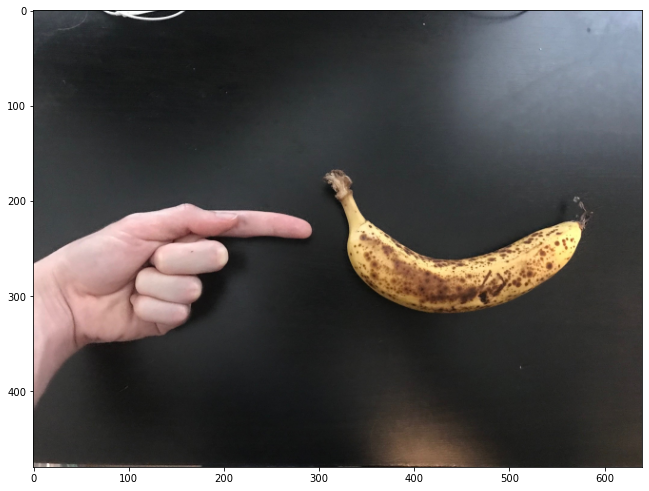

In [8]:
# Read image and resize image to (640, 480) or other dimensions
img = cv2.imread(img_path)
img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)

original_img = img.copy() # Vanilla pure image, no overlays, boxes, labels, etc
overlay = img.copy() # For mask overlay
height, width, _ = img.shape

# 0 = open until any key is pressed, then close, any other number, in milliseconds, opens window in that duration
cv2.imshow("[SIDE] Original Image ({},{})".format(width, height), img)
cv2.waitKey(0)  
cv2.destroyAllWindows()

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Inline show image in notebook

print("Width:", width)
print("Height:", height)

### 2.11 Object Detection Function

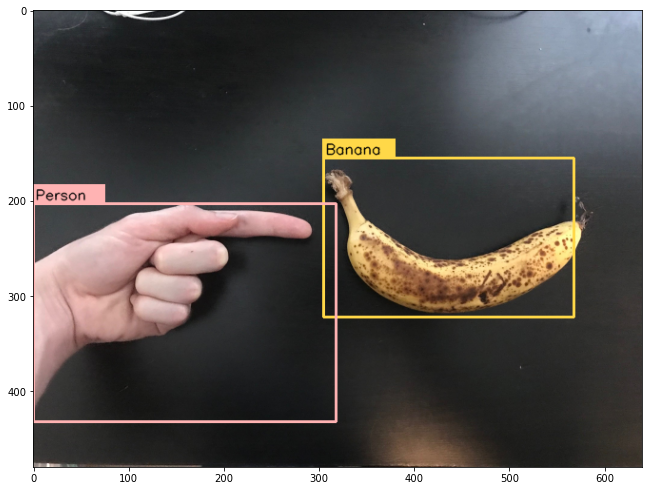

In [9]:
# For Static Image Only
object_detect_img, segmentation_img, box_list = object_detection_mask(img)
cv2.waitKey(0)
cv2.destroyAllWindows() 

# Object Detection Box Image
plt.imshow(cv2.cvtColor(object_detect_img, cv2.COLOR_BGR2RGB))

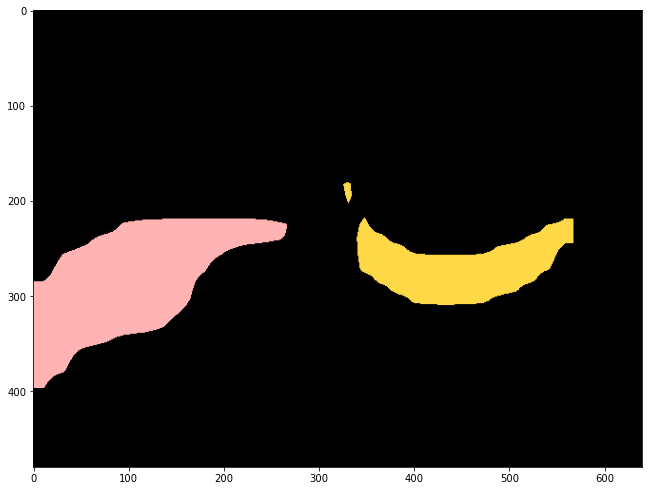

In [10]:
# Image Segmentation Box Image
plt.imshow(cv2.cvtColor(segmentation_img, cv2.COLOR_BGR2RGB))

In [11]:
# Print detected object's box details
for box in box_list:
    print(box)

[0.0, 'Banana', 0.9573536, 305, 155, 568, 322]
[0.0, 'Person', 0.8751519, 0, 203, 318, 432]


### 2.12 Item and Finger Class 

In [12]:
# Create instances of Class Item and Finger from box_list of input image
objects = []
finger = None # Stays as None if no finger detected in side image
for box in box_list:
    if box[1] == "Person":
        finger = Finger(original_img, segmentation_img, box, object_detect_img)
    else:
        objects.append(Item(original_img, segmentation_img, box, object_detect_img))

# Sort items in the image left to right by x1 coordinate (top left corner of object detection box)
objects = sorted(objects, key=lambda item: item.get_rectangle_coods_top_left()[0])
print("---------------- FINGER CLASS [side] ----------------")
print(finger)

print("---------------- FRUIT/VEGETABLES [side] ----------------")
for item in objects:
    print(item)

---------------- FINGER CLASS [side] ----------------
SIDE: [0.0, 'Person', 0.8751519, 0, 203, 318, 432]
TOP: None

---------------- FRUIT/VEGETABLES [side] ----------------
SIDE: [0.0, 'Banana', 0.9573536, 305, 155, 568, 322]
TOP: None



Window-Width: 318
Window-Height: 229
Vertical Line Width Point: 264
Offset Width Vertical Line: 32
Finger's Width (cm): 1.48
Vertical Lines Width Ratio Offset: 0.1 

Number of pixels in finger's height from inner vertical line: 27
Number of pixels in 1cm line: 18
Number of pixels in 1cm x 1cm square: 324


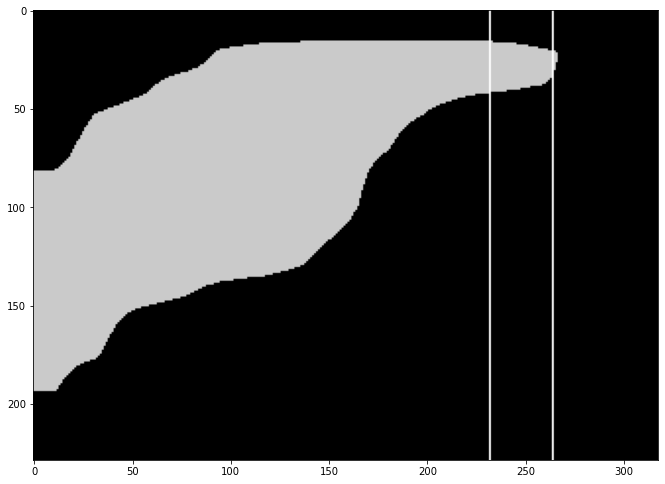

In [13]:
finger.debugging_finger_2_lines()

Number of pixels in 1cm line: 18
Number of pixels in 1cm x 1cm square: 324


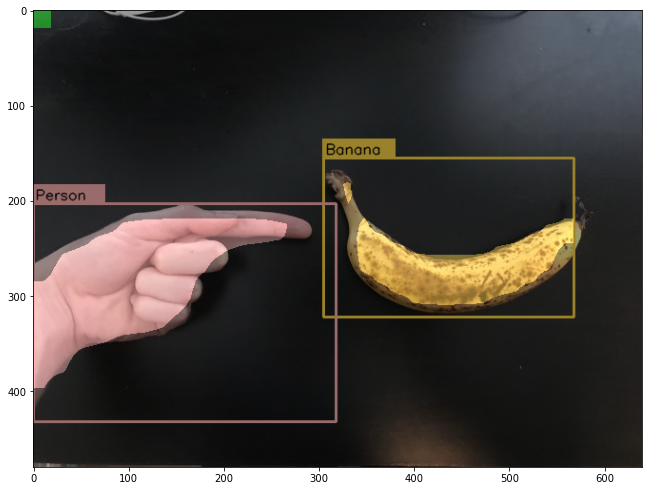

In [14]:
finger.debugging_calibration()

Window-Width: 263
Window-Height: 167
Left Vertical Line Width Point: 23
Right Vertical Line Width Point: 262
Middle Vertical Line Width Point: 142
Number of pixels in middle line: 52


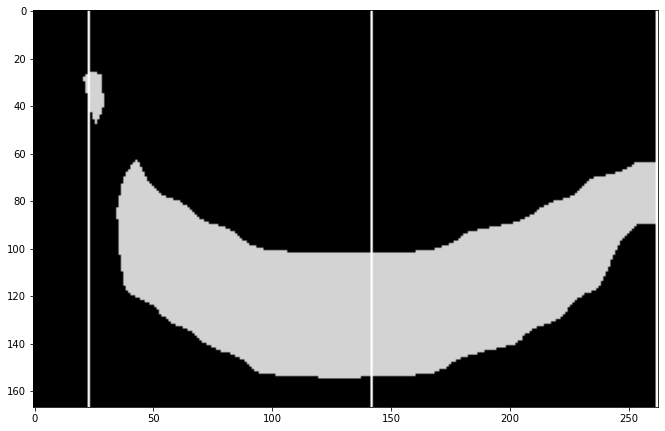

In [15]:
objects[0].debugging_finger_3_lines_banana()

In [16]:
objects[0].pixels_per_cm

### 2.13 Set Finger Calibration (SIDE)

In [17]:
# TRY WITH APPLE/ORANGE (SPHERICAL SHAPE) TODO
if finger:
    print("FRUIT/VEGETABLE STATS [SIDE VIEW]") 
    print("-------------------------------------------------")
    for item in objects:
        # Set calibration
        item.set_calibration_pixel_finger(finger.pixels_length_per_cm_FINGER)

        # Calculate volume side
        item.set_volume_side()

        # Calculate mass and calorie (might just combine the 3 set functions into one, but this is only the side though)
        item.set_mass_and_calory()

        print(f'{item.get_name()} area [SIDE] (cm2): {item.get_item_area_cm2()}')
        print(f'{item.get_name()} volume (cm3): {item.get_volume_cm3()}')
        print(f'{item.get_name()} mass (grams): {item.get_mass()}')
        print(f'{item.get_name()} calories: {item.get_calorie()}')
        print("-------------------------------------------------")
else:
    print("No finger/person detected in side image")

FRUIT/VEGETABLE STATS [SIDE VIEW]
-------------------------------------------------
Banana area [SIDE] (cm2): 34.70987654320987
Banana volume (cm3): 244.13805634182333
Banana mass (grams): 153.8069754953487
Banana calories: 136.88820819086035
-------------------------------------------------


In [18]:
orange = objects[-1]
orange.get_num_pixels()


11246

In [19]:
orange.show_3_images()

In [20]:
orange.show_grey_object()

In [24]:
box_list

[[0.0, 'Banana', 0.9573536, 305, 155, 568, 322],
 [0.0, 'Person', 0.8751519, 0, 203, 318, 432]]

## 2.2 Top View Image 

In [21]:
# Load image
img_file_TOP = "orange-finger-459f7602-1302-11ed-b13e-95c0acd580f9.jpg"
img_path_TOP = os.path.join("WebCam_images", img_file_TOP)

print(img_path_TOP)

WebCam_images\orange-finger-459f7602-1302-11ed-b13e-95c0acd580f9.jpg


In [22]:
# Read image and resize image to (640, 480) or other dimensions
img_TOP = cv2.imread(img_path_TOP)
img_TOP = cv2.resize(img_TOP, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)

original_img_TOP = img_TOP.copy() # Vanilla pure image, no overlays, boxes, labels, etc
overlay_TOP = img_TOP.copy() # For mask overlay
height_TOP, width_TOP, _ = img_TOP.shape

# 0 = open until any key is pressed, then close, any other number, in milliseconds, opens window in that duration
cv2.imshow("[TOP] Original Image ({},{})".format(width_TOP, height_TOP), img_TOP)
cv2.waitKey(0)  
cv2.destroyAllWindows()

plt.imshow(cv2.cvtColor(img_TOP, cv2.COLOR_BGR2RGB))  # Inline show image in notebook

print("Width:", width_TOP)
print("Height:", height_TOP)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


### 2.21 Object Detection Function

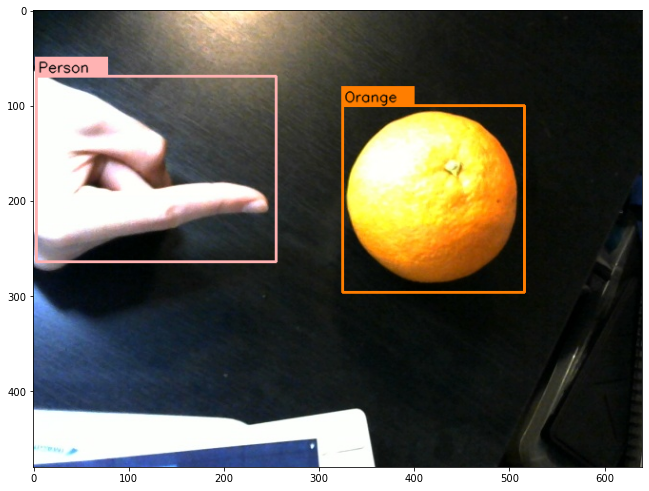

In [ ]:
# For Static Image Only
object_detect_img_TOP, segmentation_img_TOP, box_list_TOP = object_detection_mask(img_TOP)
cv2.waitKey(0)
cv2.destroyAllWindows() 

# Object Detection Box Image
plt.imshow(cv2.cvtColor(object_detect_img_TOP, cv2.COLOR_BGR2RGB))

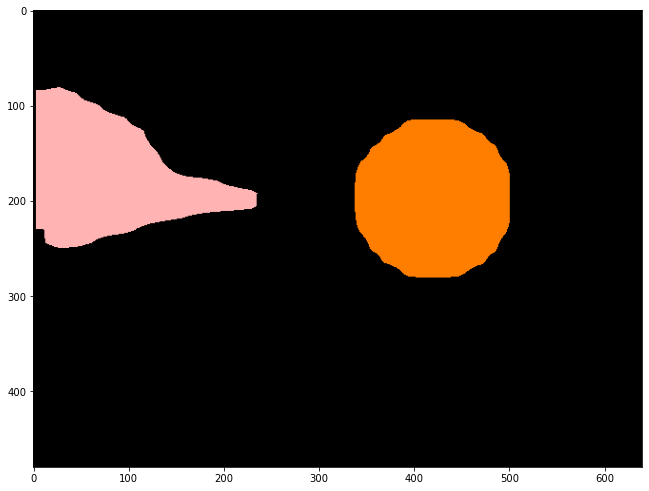

In [ ]:
# Image Segmentation Box Image
plt.imshow(cv2.cvtColor(segmentation_img_TOP, cv2.COLOR_BGR2RGB))

In [ ]:
# Print detected object's box details
print("[SIDE] BOX LIST:")
for box in box_list:
    print(box)
    
print("\n[TOP] BOX LIST:")
for box in box_list_TOP:
    print(box)


[SIDE] BOX LIST:
[0.0, 'Apple', 0.9516723, 349, 138, 492, 283]
[0.0, 'Person', 0.89449507, 2, 153, 296, 300]

[TOP] BOX LIST:
[0.0, 'Orange', 0.9832755, 325, 100, 516, 296]
[0.0, 'Person', 0.97092193, 3, 69, 255, 264]


### 2.22 Item and Finger Class [TOP view]


In [ ]:

# Update Finger to have details of TOP view Finger version
box_list_TOP_NO_FINGER = box_list_TOP.copy()
for i, box_TOP in enumerate(box_list_TOP_NO_FINGER):
    if box_TOP[1] == "Person":
        finger.update_initialize_top(original_img_TOP, segmentation_img_TOP, box_TOP, object_detect_img_TOP)
        finger.initialize_data(view="TOP")
        del box_list_TOP_NO_FINGER[i]

# Sort items in the image left to right by x1 coordinate (top left corner of object detection box)
box_list_TOP_NO_FINGER = sorted(box_list_TOP_NO_FINGER, key=lambda box: box[3])

print("Sorted BOX_LIST_TOP_NO_FINGER")
for derp in box_list_TOP_NO_FINGER:
    print(derp)
print()

print("Sorted Item Class (to be updated with the sorted BOX_LIST_TOP_NO_FINGER)")
for derp in objects:
    print(derp)
print()

print("Number of objects [SIDE]:", len(objects))
print("Number of objects [TOP]:", len(box_list_TOP_NO_FINGER), '\n')

for i, box_TOP in enumerate(box_list_TOP_NO_FINGER):
    objects[i].update_initialize_top(original_img_TOP, segmentation_img_TOP, box_TOP, object_detect_img_TOP)

Sorted BOX_LIST_TOP_NO_FINGER
[0.0, 'Orange', 0.9832755, 325, 100, 516, 296]

Sorted Item Class (to be updated with the sorted BOX_LIST_TOP_NO_FINGER)
SIDE: [0.0, 'Apple', 0.9516723, 349, 138, 492, 283]
TOP: None


Number of objects [SIDE]: 1
Number of objects [TOP]: 1 



In [ ]:
print("---------------- FINGER CLASS [top] ----------------")
print(finger)

print("---------------- FRUIT/VEGETABLES [top] ----------------")
for item in objects:
    print(item)

---------------- FINGER CLASS [top] ----------------
SIDE: [0.0, 'Person', 0.89449507, 2, 153, 296, 300]
TOP: [0.0, 'Person', 0.97092193, 3, 69, 255, 264]

---------------- FRUIT/VEGETABLES [top] ----------------
SIDE: [0.0, 'Apple', 0.9516723, 349, 138, 492, 283]
TOP: [0.0, 'Orange', 0.9832755, 325, 100, 516, 296]



In [23]:
finger.debugging_finger_2_lines(view="TOP")

AttributeError: 'Finger' object has no attribute 'finger_2_lines_TOP'

Number of pixels in 1cm line: 18
Number of pixels in 1cm x 1cm square: 324


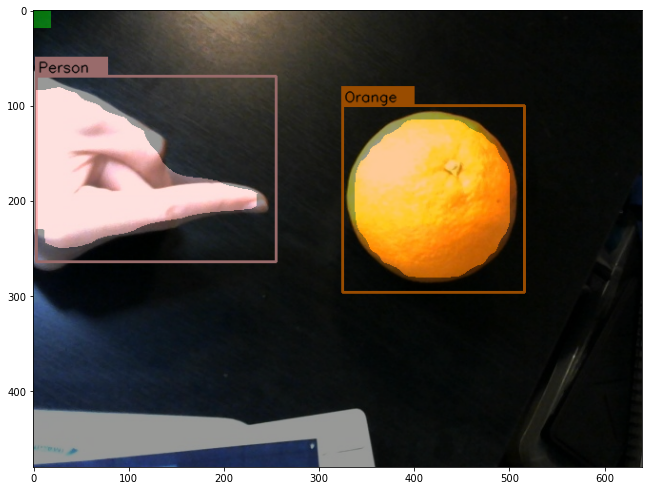

In [ ]:
finger.debugging_calibration(view="TOP")

### 2.23 Set Finger Calibration (TOP)

In [ ]:
# TRY WITH APPLE/ORANGE (SPHERICAL SHAPE) TODO
if finger: 
    print("FRUIT/VEGETABLE STATS [TOP VIEW]") 
    print("-------------------------------------------------")
    for item in objects:
        # Set calibration
        # item.set_calibration_pixel_finger(finger_TOP.pixels_length_per_cm_FINGER)
        item.set_calibration_pixel_finger(finger.pixels_length_per_cm_FINGER_TOP, view="TOP")


        # Calculate volume side [TODO for finding volume and calorie]
        # item.set_volume_side()

        # # Calculate mass and calorie (might just combine the 3 set functions into one, but this is only the side though)
        # item.set_mass_and_calory()

        print(f'{item.get_name()} area [SIDE] (cm2): {item.get_item_area_cm2()}')
        print(f'{item.get_name(view="TOP")} area [TOP] (cm2): {item.get_item_area_cm2(view="TOP")}')
        # print(f'{item.get_name(view="TOP")} volume (cm3): {item.get_volume_cm3()}')
        # print(f'{item.get_name(view="TOP")} mass (grams): {item.get_mass()}')
        # print(f'{item.get_name(view="TOP")} calories: {item.get_calorie()}')
        print("-------------------------------------------------")
else:
    print("No finger/person detected in side image")

FRUIT/VEGETABLE STATS [TOP VIEW]
-------------------------------------------------
Apple area [SIDE] (cm2): 36.634349030470915
Orange area [TOP] (cm2): 68.16358024691358
-------------------------------------------------


In [ ]:
for item in objects:
    print(item)
    item.show_3_images()
    item.show_3_images(view="TOP")

SIDE: [0.0, 'Apple', 0.9516723, 349, 138, 492, 283]
TOP: [0.0, 'Orange', 0.9832755, 325, 100, 516, 296]



In [ ]:
print(finger)
finger.show_3_images()
finger.show_3_images(view="TOP")

SIDE: [0.0, 'Person', 0.89449507, 2, 153, 296, 300]
TOP: [0.0, 'Person', 0.97092193, 3, 69, 255, 264]



In [ ]:
box_list

NameError: name 'box_list' is not defined